# Imports

In [1]:
import re
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

# Load data

In [2]:
df = (
    pd.read_json("../artifacts/data/raw/dataset.jsonl", lines=True)
    .set_index(["question_id", "sample_id"])
    .sort_index()
)
df.head()

question  \
question_id sample_id                                                      
0           0          Natalia sold clips to 48 of her friends in Apr...   
            1          Natalia sold clips to 48 of her friends in Apr...   
            2          Natalia sold clips to 48 of her friends in Apr...   
            3          Natalia sold clips to 48 of her friends in Apr...   
            4          Natalia sold clips to 48 of her friends in Apr...   

                                                        gold_answer_text  \
question_id sample_id                                                      
0           0          Natalia sold 48/2 = <<48/2=24>>24 clips in May...   
            1          Natalia sold 48/2 = <<48/2=24>>24 clips in May...   
            2          Natalia sold 48/2 = <<48/2=24>>24 clips in May...   
            3          Natalia sold 48/2 = <<48/2=24>>24 clips in May...   
            4          Natalia sold 48/2 = <<48/2=24>>24 clips in May...   

                       gold_answer_number  \
question_id sample_id                       
0           0                          72   
            1                          72   
            2                          72   
            3                          72   
            4                          72   

                                                     teacher_answer_text  \
question_id sample_id                                                      
0           0          Reasoning:\n- Clips sold in April: 48\n- Clips...   
            1          Reasoning:\n- Clips sold in April: 48\n- Clips...   
            2          Reasoning:\n- Clips sold in April: 48\n- Clips...   
            3          Reasoning:\n- Clips sold in April: 48\n- Clips...   
            4          Reasoning:\n- Clips sold in April: 48\n- Clips...   

                       teacher_answer_number  is_correct finish_reason  \
question_id sample_id                                                    
0           0                           72.0        True          stop   
            1                           72.0        True          stop   
            2                           72.0        True          stop   
            3                           72.0        True          stop   
            4                           72.0        True          stop   

                                                                   usage  \
question_id sample_id                                                      
0           0          {'prompt_tokens': 492, 'completion_tokens': 15...   
            1          {'prompt_tokens': 492, 'completion_tokens': 12...   
            2          {'prompt_tokens': 492, 'completion_tokens': 11...   
            3          {'prompt_tokens': 492, 'completion_tokens': 12...   
            4          {'prompt_tokens': 492, 'completion_tokens': 24...   

                       latency_ms                                  model  \
question_id sample_id                                                      
0           0                4095  deepseek/deepseek-r1-distill-qwen-32b   
            1                3334  deepseek/deepseek-r1-distill-qwen-32b   
            2                3450  deepseek/deepseek-r1-distill-qwen-32b   
            3                3292  deepseek/deepseek-r1-distill-qwen-32b   
            4                5826  deepseek/deepseek-r1-distill-qwen-32b   

                                                request_id  
question_id sample_id                                       
0           0          gen-1758388432-DfG37km2Lexm7CG9fckv  
            1          gen-1758389073-JlSmJOageoYiDFolyjt0  
            2          gen-1758389183-yiPtpMfRg9ujKVQWEEgj  
            3          gen-1758389312-3AT01pb2c3chInGn0fYX  
            4          gen-1758389425-OZorZUL4iltq3W6ZSMMy

In [3]:
usage_df = df["usage"].apply(
    lambda x: pd.Series(
        {
            "prompt_tokens": x["prompt_tokens"],
            "completion_tokens": x["completion_tokens"],
            "total_tokens": x["total_tokens"],
        }
    )
)
df = pd.concat([df.drop(columns="usage"), usage_df], axis=1)

In [4]:
df["teacher_answer_length"] = df["teacher_answer_text"].str.len()

# Analysis

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 30000 entries, (np.int64(0), np.int64(0)) to (np.int64(999), np.int64(29))
Data columns (total 14 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   question               30000 non-null  object 
 1   gold_answer_text       30000 non-null  object 
 2   gold_answer_number     30000 non-null  int64  
 3   teacher_answer_text    30000 non-null  object 
 4   teacher_answer_number  29984 non-null  float64
 5   is_correct             30000 non-null  bool   
 6   finish_reason          30000 non-null  object 
 7   latency_ms             30000 non-null  int64  
 8   model                  30000 non-null  object 
 9   request_id             30000 non-null  object 
 10  prompt_tokens          30000 non-null  int64  
 11  completion_tokens      30000 non-null  int64  
 12  total_tokens           30000 non-null  int64  
 13  teacher_answer_length  30000 non-null  int64  
dtypes: bo

In [6]:
df.describe()

,gold_answer_number,teacher_answer_number,latency_ms,prompt_tokens,completion_tokens,total_tokens,teacher_answer_length
count,3.000000e+04,2.998400e+04,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000
mean,3.062798e+05,1.504561e+05,6317.454867,513.208000,268.570367,781.778367,201.119067
std,6.978442e+06,4.282655e+06,4623.728134,21.397196,224.886703,230.294163,208.018264
min,0.000000e+00,-2.252000e+06,2108.000000,474.000000,65.000000,551.000000,15.000000
25%,1.300000e+01,1.300000e+01,4348.000000,497.000000,173.000000,679.000000,134.000000
50%,4.200000e+01,4.200000e+01,5435.000000,510.000000,225.000000,739.000000,173.000000
75%,1.600000e+02,1.600000e+02,7060.250000,524.000000,304.000000,827.000000,228.000000
max,1.920000e+08,1.920000e+08,200833.000000,626.000000,9950.000000,10456.000000,14600.000000


In [7]:
df["model"].unique()

array(['deepseek/deepseek-r1-distill-qwen-32b'], dtype=object)

In [8]:
df["finish_reason"].unique()

array(['stop'], dtype=object)

## Answers

In [9]:
df.groupby("question")["request_id"].count().describe()

count    1000.0
mean       30.0
std         0.0
min        30.0
25%        30.0
50%        30.0
75%        30.0
max        30.0
Name: request_id, dtype: float64

In [10]:
len(df["question"].unique())

1000

In [11]:
len(df["teacher_answer_text"].unique())

27041

In [12]:
df["is_correct"].value_counts()

is_correct
True     28124
False     1876
Name: count, dtype: int64

In [13]:
(df["gold_answer_number"] == df["teacher_answer_number"]).value_counts()

True     28124
False     1876
Name: count, dtype: int64

In [14]:
print(
    f"Accuracy: {(df['gold_answer_number'] == df['teacher_answer_number']).mean() * 100:.2f}%"
)

Accuracy: 93.75%


## Tokens and latency

In [15]:
df[["completion_tokens", "prompt_tokens", "total_tokens", "latency_ms"]].quantile(
    [0.25, 0.5, 0.75, 0.9, 0.95, 0.99]
)

,completion_tokens,prompt_tokens,total_tokens,latency_ms
0.25,173.0,497.00,679.0,4348.00
0.50,225.0,510.00,739.0,5435.00
0.75,304.0,524.00,827.0,7060.25
0.90,424.0,541.00,949.0,9533.30
0.95,532.0,552.05,1056.0,11714.15
0.99,862.0,580.01,1392.0,18487.13


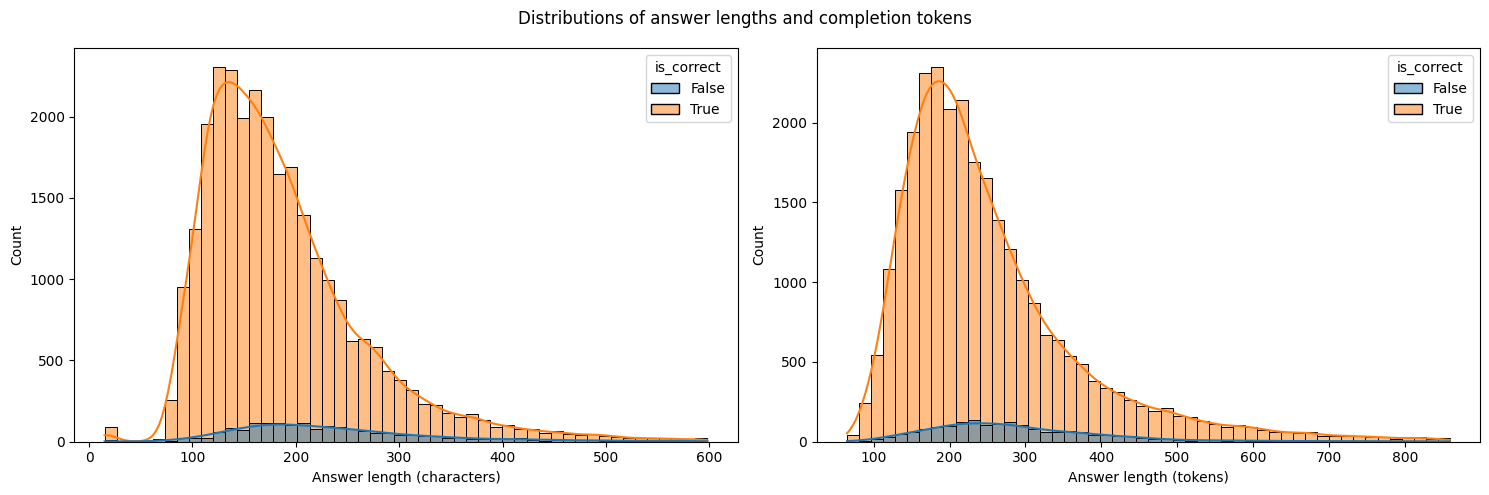

In [16]:
fig, axs = plt.subplots(1, 2, figsize=(15, 5))
fig.suptitle("Distributions of answer lengths and completion tokens")

sns.histplot(
    data=df[df["teacher_answer_length"] < df["teacher_answer_length"].quantile(0.99)],
    x="teacher_answer_length",
    bins=50,
    hue="is_correct",
    kde=True,
    ax=axs[0],
)
axs[0].set_xlabel("Answer length (characters)")

sns.histplot(
    data=df[df["completion_tokens"] < df["completion_tokens"].quantile(0.99)],
    x="completion_tokens",
    bins=50,
    hue="is_correct",
    kde=True,
    ax=axs[1],
)
axs[1].set_xlabel("Answer length (tokens)")
fig.tight_layout()

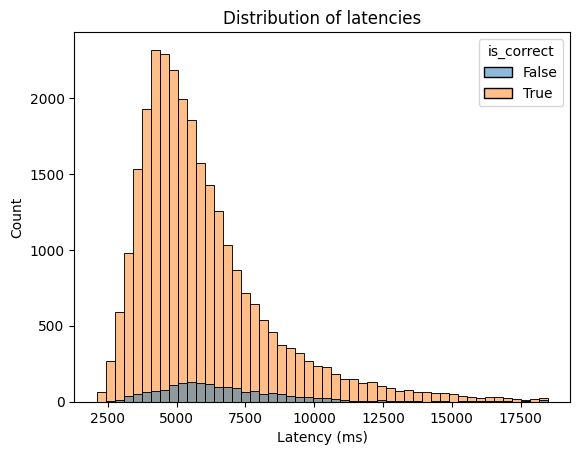

In [17]:
sns.histplot(
    data=df[df["latency_ms"] < df["latency_ms"].quantile(0.99)],
    x="latency_ms",
    hue="is_correct",
    bins=50,
)
plt.title("Distribution of latencies")
plt.xlabel("Latency (ms)")
plt.show()

## Reasoning analysis

In [18]:
df["reasoning_text"] = (
    df["teacher_answer_text"]
    .str.extract(
        r"Reasoning:\s*(.*?)\s*Final\sAnswer",
        flags=re.IGNORECASE | re.DOTALL,
        expand=False,
    )
    .str.strip()
)
df["reasoning_step_count"] = (
    df["reasoning_text"].str.count(r"^\s*[-–—]\s", flags=re.MULTILINE) + 1
)

<Axes: xlabel='reasoning_step_count', ylabel='Count'>

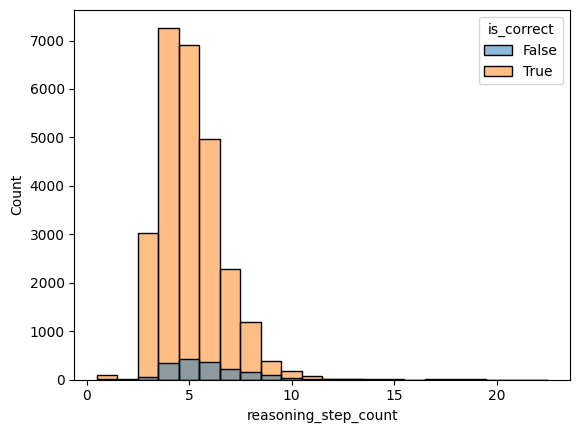

In [19]:
sns.histplot(data=df, x="reasoning_step_count", hue="is_correct", discrete=True)

## Error analysis

In [20]:
pd.set_option("display.max_colwidth", None)

mistakes = df.loc[
    ~df["is_correct"], ["question", "teacher_answer_text", "gold_answer_text"]
].copy()

for (row_idx, sample_id), row in mistakes.iterrows():
    print(f"Row {row_idx}, Sample {sample_id}")
    print("-" * 80)
    print("Question:\n", row["question"])
    print("\nTeacher answer:\n", row["teacher_answer_text"])
    print("\nGold answer:\n", row["gold_answer_text"])
    print("\n" + "=" * 80 + "\n")

Row 4, Sample 1
--------------------------------------------------------------------------------
Question:
 James writes a 3-page letter to 2 different friends twice a week.  How many pages does he write a year?

Teacher answer:
 Reasoning:
- Letters per day: 2 friends × 2 pages = 4 pages
- Letters per week: 2 days × 4 pages = 8 pages
- Letters per year: 8 pages × 52 weeks = 416 pages
Final Answer: 416

Gold answer:
 He writes each friend 3*2=<<3*2=6>>6 pages a week
So he writes 6*2=<<6*2=12>>12 pages every week
That means he writes 12*52=<<12*52=624>>624 pages a year
#### 624


Row 4, Sample 2
--------------------------------------------------------------------------------
Question:
 James writes a 3-page letter to 2 different friends twice a week.  How many pages does he write a year?

Teacher answer:
 Reasoning:
- Pages per friend: 3
- Number of friends: 2 → Total per week: 3 × 2 = 6
- Weeks in a year: 52
- Total pages per year: 6 × 52 = 312

Final Answer: 312

Gold answer:
 He writ

In [21]:
df.loc[898, ["question", "teacher_answer_text", "gold_answer_text"]]

,question,teacher_answer_text,gold_answer_text
sample_id,,,
0,"Tony wants to build the longest rope he possibly can, so he collects all the rope in his home. He finds an 8-foot rope, a 20-foot rope, three 2 foot ropes, and a 7-foot rope. each knot between the ropes makes him lose 1.2 foot per knot. How long is his rope when he's done tying them all together?",Reasoning:\n- Total length of ropes: 8 + 20 + (3×2) + 7 = 41\n- Number of ropes: 6\n- Number of knots: 6 − 1 = 5\n- Total loss from knots: 5 × 1.2 = 6\n- Final length: 41 − 6 = 35\n\nFinal Answer: 35,The combined length of all the rope is 41 feet because 8 + 20 + (2 x 3) + 7 = <<8+20+(2*3)+7=41>>41\nHe loses 6 feet from the knots because 5 x 1.2 = <<5*1.2=6>>6\nThe final length is 35 feet because 41 - 6 = <<41-6=35>>35\n#### 35
1,"Tony wants to build the longest rope he possibly can, so he collects all the rope in his home. He finds an 8-foot rope, a 20-foot rope, three 2 foot ropes, and a 7-foot rope. each knot between the ropes makes him lose 1.2 foot per knot. How long is his rope when he's done tying them all together?",Reasoning:\n1. Total length of ropes: 8 + 20 + (3×2 = 6) + 7 = 45\n2. Number of knots: 4 (since 5 ropes require 4 joins)\n3. Total length lost from knots: 4×1.2 = 4.8\n4. Final rope length: 45 − 4.8 = 40.2\nFinal Answer: 40.2,The combined length of all the rope is 41 feet because 8 + 20 + (2 x 3) + 7 = <<8+20+(2*3)+7=41>>41\nHe loses 6 feet from the knots because 5 x 1.2 = <<5*1.2=6>>6\nThe final length is 35 feet because 41 - 6 = <<41-6=35>>35\n#### 35
2,"Tony wants to build the longest rope he possibly can, so he collects all the rope in his home. He finds an 8-foot rope, a 20-foot rope, three 2 foot ropes, and a 7-foot rope. each knot between the ropes makes him lose 1.2 foot per knot. How long is his rope when he's done tying them all together?",Reasoning:\n- Total rope length: \(8 + 20 + 3 \times 2 + 7 = 8 + 20 + 6 + 7 = 41\) feet\n- Number of knots: \(1 + 1 + 1 + 3 - 1 = 5\) knots (connecting 6 ropes requires 5 knots)\n- Total length lost due to knots: \(5 \times 1.2 = 6\) feet\n- Final rope length: \(41 - 6 = 35\) feet\n\nFinal Answer: 35,The combined length of all the rope is 41 feet because 8 + 20 + (2 x 3) + 7 = <<8+20+(2*3)+7=41>>41\nHe loses 6 feet from the knots because 5 x 1.2 = <<5*1.2=6>>6\nThe final length is 35 feet because 41 - 6 = <<41-6=35>>35\n#### 35
3,"Tony wants to build the longest rope he possibly can, so he collects all the rope in his home. He finds an 8-foot rope, a 20-foot rope, three 2 foot ropes, and a 7-foot rope. each knot between the ropes makes him lose 1.2 foot per knot. How long is his rope when he's done tying them all together?",Reasoning:\n- Total rope length before knots: 8 + 20 + (3×2) + 7 = 8 + 20 + 6 + 7 = 41\n- Number of knots needed: 4 ropes - 1 = 3 (since 3 additional knots to join)\n- Total length lost due to knots: 3 knots × 1.2 feet/knot = 3.6\n- Final rope length: 41 - 3.6 = 37.4\n\nFinal Answer: 37.4,The combined length of all the rope is 41 feet because 8 + 20 + (2 x 3) + 7 = <<8+20+(2*3)+7=41>>41\nHe loses 6 feet from the knots because 5 x 1.2 = <<5*1.2=6>>6\nThe final length is 35 feet because 41 - 6 = <<41-6=35>>35\n#### 35
4,"Tony wants to build the longest rope he possibly can, so he collects all the rope in his home. He finds an 8-foot rope, a 20-foot rope, three 2 foot ropes, and a 7-foot rope. each knot between the ropes makes him lose 1.2 foot per knot. How long is his rope when he's done tying them all together?",Reasoning:\n- Total rope: 8 + 20 + (3×2) + 7 = 41\n- Number of knots: 4 − 1 = 3\n- Total loss: 3 × 1.2 = 3.6\n- Final rope length: 41 − 3.6 = 37.4\n\nFinal Answer: 37.4,The combined length of all the rope is 41 feet because 8 + 20 + (2 x 3) + 7 = <<8+20+(2*3)+7=41>>41\nHe loses 6 feet from the knots because 5 x 1.2 = <<5*1.2=6>>6\nThe final length is 35 feet because 41 - 6 = <<41-6=35>>35\n#### 35
5,"Tony wants to build the longest rope he possibly can, so he collects all the rop

## Cost analysis

In [22]:
COST_PER_M_INPUT_TOKENS = 0.27
COST_PER_M_OUTPUT_TOKENS = 0.27
df["cost_usd"] = (
    df["prompt_tokens"] * COST_PER_M_INPUT_TOKENS / 1_000_000
    + df["completion_tokens"] * COST_PER_M_OUTPUT_TOKENS / 1_000_000
)
print(
    f"Total cost: ${df['cost_usd'].sum():.5f}, Average cost: ${df['cost_usd'].mean():.5f}, Median cost: ${df['cost_usd'].median():.5f}, Stddev: ${df['cost_usd'].std():.6f}"
)

Total cost: $6.33240, Average cost: $0.00021, Median cost: $0.00020, Stddev: $0.000062


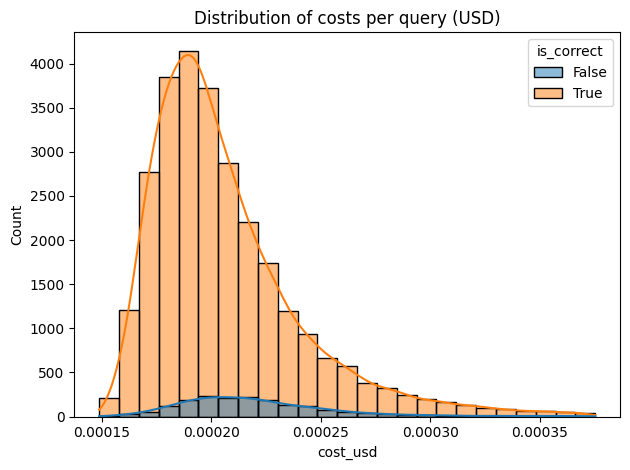

In [23]:
sns.histplot(
    data=df[df["cost_usd"] < df["cost_usd"].quantile(0.99)],
    x="cost_usd",
    bins=25,
    kde=True,
    hue="is_correct",
)
plt.title("Distribution of costs per query (USD)")
plt.tight_layout()